# Titanic Competition
Link: https://www.kaggle.com/competitions/titanic/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, log_loss, fbeta_score, make_scorer, accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from tqdm import tqdm

## EDA

In [2]:
pd.read_csv('titanic/gender_submission.csv').head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [3]:
df_train = pd.read_csv('titanic/train.csv')
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
df_test = pd.read_csv('titanic/test.csv')
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Feature Engineering

In [46]:
titles = [
    'Mr.', 'Mrs.', 'Miss.', 'Ms.', 'Mme.', 'Mlle.', 'Master.',
    'Rev.', 'Dr.', 'Don.', 'Dona.', 'Major.', 'Lady.', 'Sir.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.'
]

entitled_regex = 'Rev\\.|Dr\\.|Don\\.|Dona\\.|Major\\.|Lady\\.|Sir\\.|Col\\.|Capt\\.|Countess\\.|Jonkheer\\.'
normalized_title_mapping = {
    'Mlle.': 'Miss.',
    'Ms.': 'Miss.',
    'Mme.': 'Mrs.',
    'Dr.': 'Other.',
    'Rev.': 'Other.',
    'Don.': 'Other.',
    'Dona.': 'Other.',
    'Sir.': 'Other.',
    'Jonkheer.': 'Other.',
    'Lady.': 'Other.',
    'Countess.': 'Other.',
    'Major.': 'Other.',
    'Col.': 'Other.',
    'Capt.': 'Other.',
    # Retained - Mr., Miss., Master.
}

def extract_title(name):
    if pd.isna(name):
        return 'Unknown'
    
    for title in titles:
        if title in name:
            return normalized_title_mapping.get(title, title)
    
    return 'Unknown'

X_train = df_train.copy()
X_test = df_test.copy()

X_train['Title'] = X_train['Name'].apply(extract_title)
X_test['Title'] = X_test['Name'].apply(extract_title)

embarked_mode = X_train['Embarked'].mode()
X_train['Embarked'] = X_train['Embarked'].fillna(embarked_mode)
X_train['Embarked'] = X_train['Embarked'].fillna(embarked_mode)

cat = ['Sex', 'Pclass', 'Title']
X_age = pd.concat([X_train[cat + ['Age']], X_test[cat + ['Age']]], ignore_index=True)
X_age_median = round(X_age.dropna().groupby(cat, as_index=True).median(),1)

def fill_age_by_cat(age, sex, pclass, title):
    if pd.notna(age):
        return age
    return X_age_median['Age'][sex][pclass][title]

X_train['AgeTrans'] = X_train.apply(lambda x: fill_age_by_cat(x.Age, x.Sex, x.Pclass, x.Title), axis=1)
X_test['AgeTrans'] = X_test.apply(lambda x: fill_age_by_cat(x.Age, x.Sex, x.Pclass, x.Title), axis=1)

X_train['AgeTrans'], age_lambda_param = yeojohnson(X_train['AgeTrans'])
X_test['AgeTrans'] = yeojohnson(X_test['AgeTrans'], lmbda=age_lambda_param)

X_train['FamilySize'] = 1 + X_train['Parch'] + X_train['SibSp']
X_test['FamilySize'] = 1 + X_test['Parch'] + X_test['SibSp']

X_train['FamilyBucket'] = pd.cut(X_train['FamilySize'], bins=[0, 1, 4, 20], labels=[2, 3, 1])
X_test['FamilyBucket'] = pd.cut(X_test['FamilySize'], bins=[0, 1, 4, 20], labels=[2, 3, 1])

/var/folders/q3/14lgwyts2qnfqxtwkryq59n40000gn/T/ipykernel_49859/3853952147.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  array = np.array([[X[i], Y[i]] for i in range(len(X))])


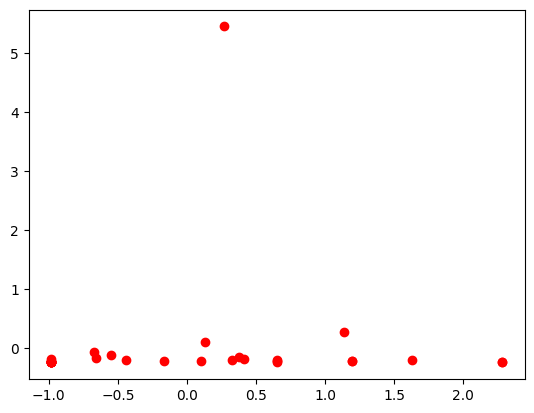

In [47]:
def get_ticket_code(ticket):
    if pd.isna(ticket) or ticket.isdigit():
        return 'MISSING'
    return ticket.replace('.', '').replace('/', '').split(' ')[0]

X_train['TicketCode'] = X_train['Ticket'].apply(get_ticket_code)
X_test['TicketCode'] = X_test['Ticket'].apply(get_ticket_code)

X = X_train.groupby('TicketCode')['Survived'].mean()
Y = X_train.groupby('TicketCode')['Survived'].count()

X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

array = np.array([[X[i], Y[i]] for i in range(len(X))])
plt.plot(X, Y, 'ro')
plt.show()

          X         Y  label TicketCode
0 -0.982387 -0.187279      0         A4
1 -0.671617 -0.066687      0         A5
2 -0.982387 -0.238961      0         AS


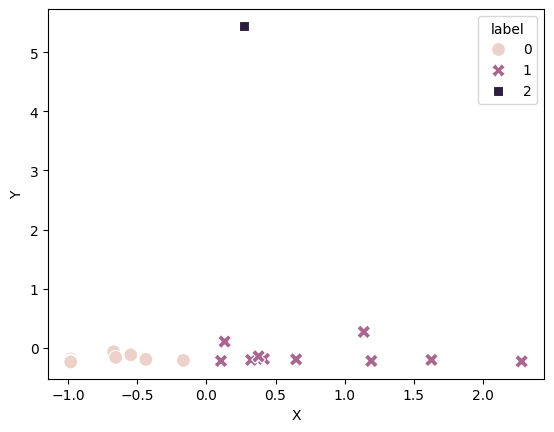

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(array)
df_clusters = pd.DataFrame(array, columns=['X', 'Y'])
df_clusters['label'] = kmeans.labels_
df_clusters['TicketCode'] = X_train.groupby('TicketCode')['Survived'].mean().reset_index()['TicketCode']
print(df_clusters.head(3))

sns.scatterplot(data=df_clusters, x='X', y='Y', style='label', hue='label', s=100)
plt.show()

In [49]:
ticket_code_dict = df_clusters.set_index('TicketCode')['label'].to_dict()

X_train['TicketCodeLabel'] = X_train['TicketCode'].apply(lambda val: ticket_code_dict[val])
ticket_code_label_mode = X_train['TicketCodeLabel'].mode()[0]
X_test['TicketCodeLabel'] = X_test['TicketCode'].apply(lambda val: ticket_code_dict.get(val, ticket_code_label_mode))

X_train.groupby('TicketCodeLabel')['Survived'].mean()

TicketCodeLabel
0    0.092105
1    0.525974
2    0.384266
Name: Survived, dtype: float64

In [50]:
fare_median = X_train['Fare'].median()
X_train['Fare'] = X_train['Fare'].fillna(fare_median)
X_test['Fare'] = X_test['Fare'].fillna(fare_median)

X_train['FareTrans'], fare_lambda_param = yeojohnson(X_train['Fare'])
X_test['FareTrans'] = yeojohnson(X_test['Fare'], lmbda=fare_lambda_param)

In [51]:
pclass_dict = {1:1, 2:0, 3:-1}
X_train['PclassTrans'] = X_train['Pclass'].map(pclass_dict)
X_test['PclassTrans'] = X_test['Pclass'].map(pclass_dict)

/var/folders/q3/14lgwyts2qnfqxtwkryq59n40000gn/T/ipykernel_49859/1821636324.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  array = np.array([[X[i], Y[i]] for i in range(len(X))])


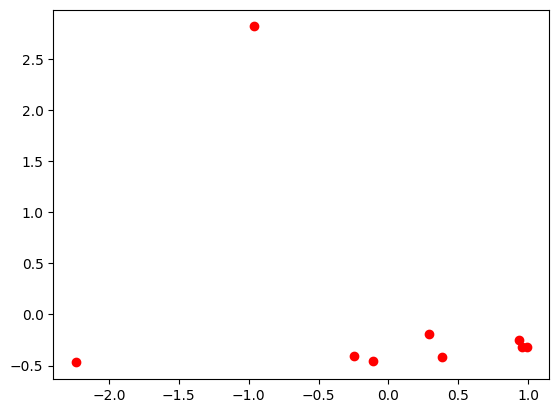

In [52]:
def get_cabin_prefix(cabin):
    if pd.isna(cabin):
        return 'MISSING'
    return cabin[0]

X_train['CabinPrefix'] = X_train['Cabin'].apply(get_cabin_prefix)
X_test['CabinPrefix'] = X_test['Cabin'].apply(get_cabin_prefix)

X = X_train.groupby('CabinPrefix')['Survived'].mean()
Y = X_train.groupby('CabinPrefix')['Survived'].count()

X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

array = np.array([[X[i], Y[i]] for i in range(len(X))])
plt.plot(X, Y, 'ro')
plt.show()

          X         Y  label CabinPrefix
0 -0.249575 -0.402506      0           A
1  0.934516 -0.249170      0           B
2  0.289430 -0.191669      0           C


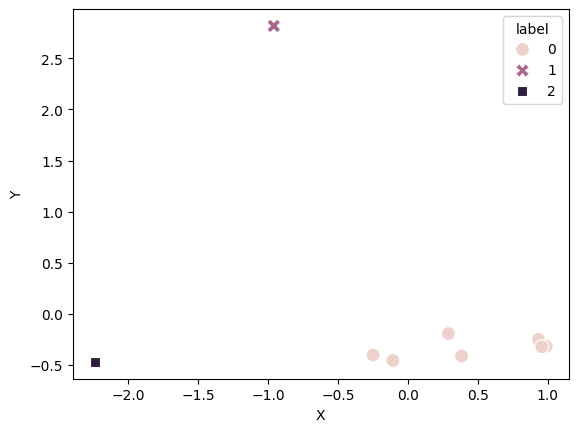

In [53]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(array)
df_clusters = pd.DataFrame(array, columns=['X', 'Y'])
df_clusters['label'] = kmeans.labels_
df_clusters['CabinPrefix'] = X_train.groupby('CabinPrefix')['Survived'].mean().reset_index()['CabinPrefix']
print(df_clusters.head(3))

sns.scatterplot(data=df_clusters, x='X', y='Y', style='label', hue='label', s=100)
plt.show()

In [54]:
cabin_prefix_dict = df_clusters.set_index('CabinPrefix')['label'].to_dict()

X_train['CabinPrefixLabel'] = X_train['CabinPrefix'].apply(lambda val: cabin_prefix_dict[val])
X_test['CabinPrefixLabel'] = X_test['CabinPrefix'].apply(lambda val: cabin_prefix_dict[val])

X_train.groupby('CabinPrefixLabel')['Survived'].mean()

CabinPrefixLabel
0    0.669951
1    0.299854
2    0.000000
Name: Survived, dtype: float64

In [55]:
X_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'AgeTrans',
       'FamilySize', 'FamilyBucket', 'TicketCode', 'TicketCodeLabel',
       'FareTrans', 'PclassTrans', 'CabinPrefix', 'CabinPrefixLabel'],
      dtype='object')

In [56]:
selected_cols = ['Sex', 'Embarked', 'Title', 'AgeTrans', 'FamilyBucket', 'TicketCodeLabel', 'FareTrans', 'PclassTrans', 'CabinPrefixLabel']
X_train_final = X_train[selected_cols]
X_test_final = X_test[selected_cols]

Y_train_final = X_train['Survived']

In [57]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Sex               891 non-null    object  
 1   Embarked          889 non-null    object  
 2   Title             891 non-null    object  
 3   AgeTrans          891 non-null    float64 
 4   FamilyBucket      891 non-null    category
 5   TicketCodeLabel   891 non-null    int64   
 6   FareTrans         891 non-null    float64 
 7   PclassTrans       891 non-null    int64   
 8   CabinPrefixLabel  891 non-null    int64   
dtypes: category(1), float64(2), int64(3), object(3)
memory usage: 56.8+ KB


In [58]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Sex               418 non-null    object  
 1   Embarked          418 non-null    object  
 2   Title             418 non-null    object  
 3   AgeTrans          418 non-null    float64 
 4   FamilyBucket      418 non-null    category
 5   TicketCodeLabel   418 non-null    int64   
 6   FareTrans         418 non-null    float64 
 7   PclassTrans       418 non-null    int64   
 8   CabinPrefixLabel  418 non-null    int64   
dtypes: category(1), float64(2), int64(3), object(3)
memory usage: 26.8+ KB


In [59]:
X_train_final = pd.get_dummies(X_train_final, prefix = 'cat', drop_first=True)
X_test_final = pd.get_dummies(X_test_final, prefix = 'cat', drop_first=True)

In [60]:
models = [
    Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression())
    ]),
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1),
    KNeighborsClassifier(),
    XGBClassifier(),
]

In [61]:
kfold = StratifiedKFold(n_splits=10)

cv_results = []
cv_names = []
cv_means = []
cv_std = []

for model in  models:
    cv_result = cross_val_score(model, X_train_final, y=Y_train_final, scoring='accuracy', cv=kfold, n_jobs=4)
    cv_results.append(cv_result)
    cv_names.append(model.__class__.__name__)
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


cv_res = pd.DataFrame({
    'CrossValMeans': cv_means,
    'CrossValErrors': cv_std,
    'Algorithm': cv_names
})

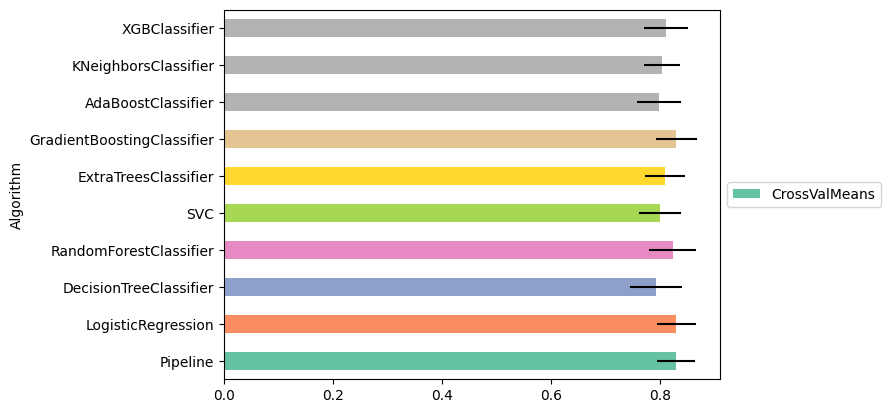

In [62]:
colors = cm.Set2(range(len(cv_res)))
cv_res.plot(kind='barh', y='CrossValMeans', x='Algorithm', xerr=cv_std, color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [63]:
cv_res['criterion'] = cv_res['CrossValMeans'] - (cv_res['CrossValErrors']/2)
cv_res.sort_values(by='criterion', ascending=False)

,CrossValMeans,CrossValErrors,Algorithm,criterion
1,0.830524,0.035346,LogisticRegression,0.812852
6,0.830537,0.037029,GradientBoostingClassifier,0.812022
0,0.829388,0.034812,Pipeline,0.811982
3,0.823820,0.042817,RandomForestClassifier,0.802412
5,0.809251,0.036267,ExtraTreesClassifier,0.791118
9,0.811486,0.041164,XGBClassifier,0.790903
8,0.804744,0.033196,KNeighborsClassifier,0.788146
4,0.800225,0.038524,SVC,0.780963
7,0.798015,0.040301,AdaBoostClassifier,0.777865
2,0.792397,0.047853,DecisionTreeClassifier,0.768471


In [64]:
for algo, model in zip(cv_names, models):
    print(f'predicting: {algo}')
    model.fit(X_train_final, Y_train_final)
    y_pred = model.predict(X_test_final)
    
    y_test = pd.concat([X_test[['PassengerId']], pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
    print(y_test.head(2))
    
    output_file = f'titanic_output/Raw_{algo}.csv'
    y_test.to_csv(output_file, index=False)

predicting: Pipeline
   PassengerId  Survived
0          892         0
1          893         1
predicting: LogisticRegression
   PassengerId  Survived
0          892         0
1          893         1
predicting: DecisionTreeClassifier
   PassengerId  Survived
0          892         0
1          893         1
predicting: RandomForestClassifier
   PassengerId  Survived
0          892         0
1          893         0
predicting: SVC
   PassengerId  Survived
0          892         0
1          893         1
predicting: ExtraTreesClassifier
   PassengerId  Survived
0          892         0
1          893         0
predicting: GradientBoostingClassifier
   PassengerId  Survived
0          892         0
1          893         1
predicting: AdaBoostClassifier
   PassengerId  Survived
0          892         0
1          893         1
predicting: KNeighborsClassifier
   PassengerId  Survived
0          892         0
1          893         1
predicting: XGBClassifier
   PassengerId  Survived


In [65]:
LR = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=5000, solver='saga'))
])
lr_param_grid = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': np.logspace(-2, 2, 100)
}

gsLR = GridSearchCV(LR, param_grid=lr_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsLR.fit(X_train_final, Y_train_final)
LR_best = gsLR.best_estimator_

print('params', LR_best.get_params())
gsLR.best_score_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
params {'memory': None, 'steps': [('scaler', StandardScaler()), ('logistic', LogisticRegression(C=np.float64(0.11233240329780277), max_iter=5000,
                   penalty='l1', solver='saga'))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'logistic': LogisticRegression(C=np.float64(0.11233240329780277), max_iter=5000,
                   penalty='l1', solver='saga'), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'logistic__C': np.float64(0.11233240329780277), 'logistic__class_weight': None, 'logistic__dual': False, 'logistic__fit_intercept': True, 'logistic__intercept_scaling': 1, 'logistic__l1_ratio': None, 'logistic__max_iter': 5000, 'logistic__multi_class': 'deprecated', 'logistic__n_jobs': None, 'logistic__penalty': 'l1', 'logistic__random_state': None, 'logistic__solver': 'saga', 'logistic__tol': 0.0001, 'logistic__verbose': 0, 'logistic__warm_start': False}


np.float64(0.8338951310861423)

In [66]:
RF = RandomForestClassifier()
rf_param_grid = {
    "max_depth": [int(x) for x in np.linspace(1, 20, num = 5)] + [None],
    "max_features": ['log2', 'sqrt', None],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
    "bootstrap": [True, False],
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 1400, num = 4)],
    "criterion": ['gini']
}

gsRF = GridSearchCV(RF, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRF.fit(X_train_final, Y_train_final)
RF_best = gsRF.best_estimator_

print('params', RF_best.get_params())
gsRF.best_score_

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
params {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


np.float64(0.8406367041198501)

In [67]:
GB = GradientBoostingClassifier()
gb_param_grid = {
    'loss' : ['log_loss'],
    'n_estimators' : [1, 2, 4, 32, 100, 150, 200, 300],
    'learning_rate': [1, 0.25, 0.1, 0.05, 0.01],
    'max_depth': [1, 2, 4, 8, 16, 32],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [0.5, 0.3, 0.1]
}

gsGB = GridSearchCV(GB, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGB.fit(X_train_final, Y_train_final)

GB_best = gsGB.best_estimator_

print(GB_best.get_params())
gsGB.best_score_

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.25, 'loss': 'log_loss', 'max_depth': 2, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


np.float64(0.8440449438202247)

In [68]:
SV = SVC(probability=True)
sv_param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100,200,300, 1000, 3000]
}

gsSV = GridSearchCV(SV, param_grid=sv_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSV.fit(X_train_final, Y_train_final)

SV_best = gsSV.best_estimator_

print(SV_best.get_params())
gsSV.best_score_

Fitting 10 folds for each of 66 candidates, totalling 660 fits
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


np.float64(0.8327715355805244)

In [69]:
XGB = XGBClassifier()
xgb_param_grid = {
    'min_child_weight': np.linspace(1, 10, 5, endpoint=True),
    'gamma': np.linspace(0.5, 5, 5, endpoint=True),
    'subsample': np.linspace(0.5, 1, 5, endpoint=True),
    'colsample_bytree': np.linspace(0.5, 1, 5, endpoint=True),
    'max_depth': [1, 2, 4, 8, 10],
}

gsXGB = GridSearchCV(XGB, param_grid=xgb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsXGB.fit(X_train_final, Y_train_final)

XGB_best = gsXGB.best_estimator_

print(XGB_best.get_params())
gsXGB.best_score_

Fitting 10 folds for each of 3125 candidates, totalling 31250 fits
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': np.float64(0.5), 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': np.float64(0.5), 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': np.float64(10.0), 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': np.float64(0.75), 'tree_method': None, 'validate_par

np.float64(0.8462546816479399)

In [71]:
test_Survived_LR = pd.Series(LR_best.predict(X_test_final), name="LR")
test_Survived_RF = pd.Series(RF_best.predict(X_test_final), name="RF")
test_Survived_GB = pd.Series(GB_best.predict(X_test_final), name="GB")
test_Survived_SV = pd.Series(SV_best.predict(X_test_final), name="SV")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test_final), name="XGB")

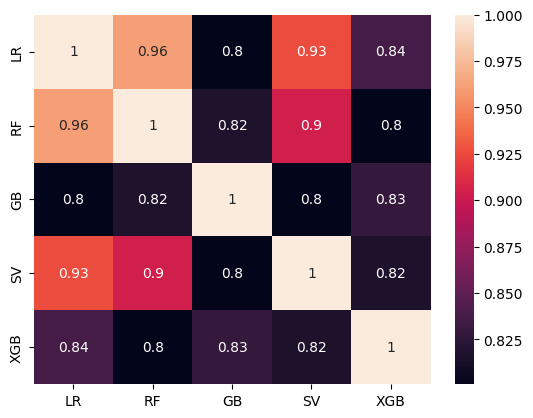

In [72]:
ensemble_results = pd.concat([
    test_Survived_LR,
    test_Survived_RF,
    test_Survived_GB,
    test_Survived_SV,
    test_Survived_XGB
],axis=1)
g= sns.heatmap(ensemble_results.corr(), annot=True)

In [73]:
votingC = VotingClassifier(estimators=[
    ('LR', LR_best),
    ('RF', RF_best),
    ('GB', GB_best),
    ('SV', SV_best),
    ('XGB', XGB_best)
], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train_final, Y_train_final)
y_pred = votingC.predict(X_test_final)

y_test = pd.concat([X_test[['PassengerId']], pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
print(y_test.head(2))

output_file = f'titanic_output/VotingC.csv'
y_test.to_csv(output_file, index=False)

   PassengerId  Survived
0          892         0
1          893         0
